<a href="https://colab.research.google.com/github/FunmilolaAdetuwo/Research-Methods-7PAM2015-Large-Language-models-LLMs-Assignment/blob/main/LLM_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMDB Dataset- Movie Review**

## **INTRODUCTION**



In [34]:
# installing the tools that will be used for building, fine-tuning and deploying LLMs when working with Natural language processing dataset

!pip install transformers datasets torch
!pip install keras-tuner
!pip install optuna
!pip install wordcloud
!pip install Flask


In [35]:
# Loading the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from wordcloud import WordCloud
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
import keras_tuner as kt
import optuna
import torch
from torch.cuda.amp import GradScaler, autocast
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from flask import Flask, request, jsonify

In [3]:
# setting up the code that ensures that the Dataframe is displayed in a pandas output

pd.options.display.max_columns = None
pd.options.display.max_rows = 20

## **Methodology**

In [4]:
# Let's load the IMDB Dataset
dt = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# then, we will convert the training and test data to a Pandas DataFrame
trn_dt = pd.DataFrame(dt['train'])
tst_dt = pd.DataFrame(dt['test'])


In [6]:
# showing the few rows of the training dataset
print(trn_dt.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


## **3. Exploratory Data Analysis (EDA)**

In [7]:
# lets starts by checking the shape of the dataset
print(f"Data Shape of the Training Dataset: {trn_dt.shape}")
print(f"Data Shape of the Test Dataset: {tst_dt.shape}")

Data Shape of the Training Dataset: (25000, 2)
Data Shape of the Test Dataset: (25000, 2)


In [8]:
# let's check if we have missing values
print(trn_dt.isnull().sum())

# then check the summary statistics
print(trn_dt.describe())

text     0
label    0
dtype: int64
             label
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000


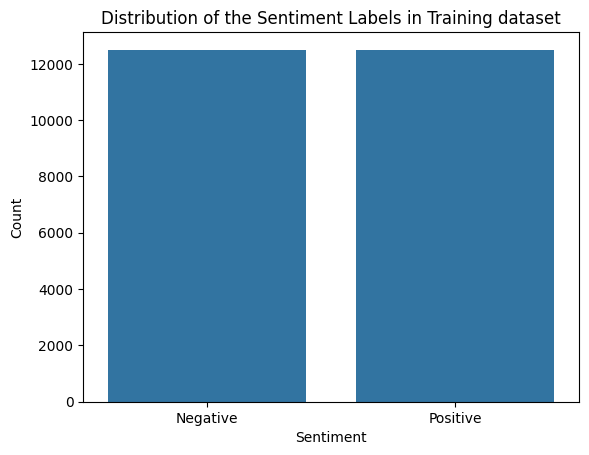

In [9]:
# let's show the distribution of our target variable which is sentiment

sns.countplot(x='label', data=trn_dt)
plt.title('Distribution of the Sentiment Labels in Training dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

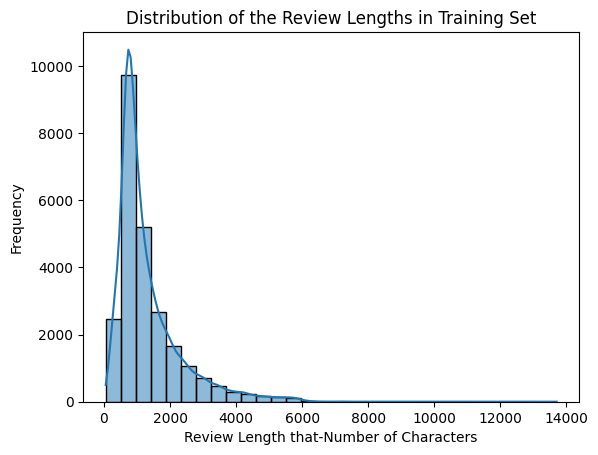

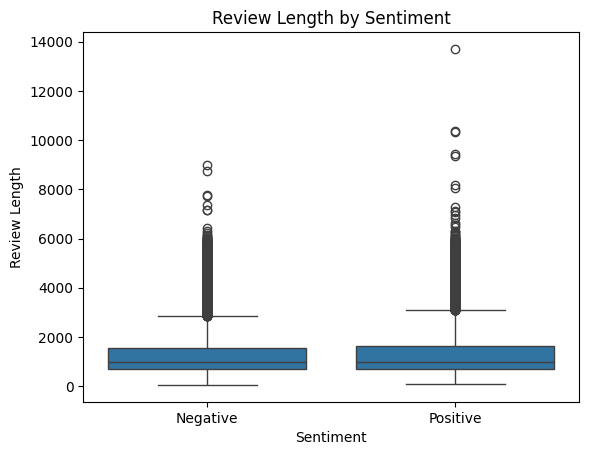

In [10]:
# let us review the length analysis

# first, we calculate the length of each review
trn_dt['review_length'] = trn_dt['text'].apply(len)

# showing the distribution of the review lengths
sns.histplot(trn_dt['review_length'], kde=True, bins=30)
plt.title('Distribution of the Review Lengths in Training Set')
plt.xlabel('Review Length that-Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Comparing the  review lengths across the sentiment categories
sns.boxplot(x='label', y='review_length', data=trn_dt)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

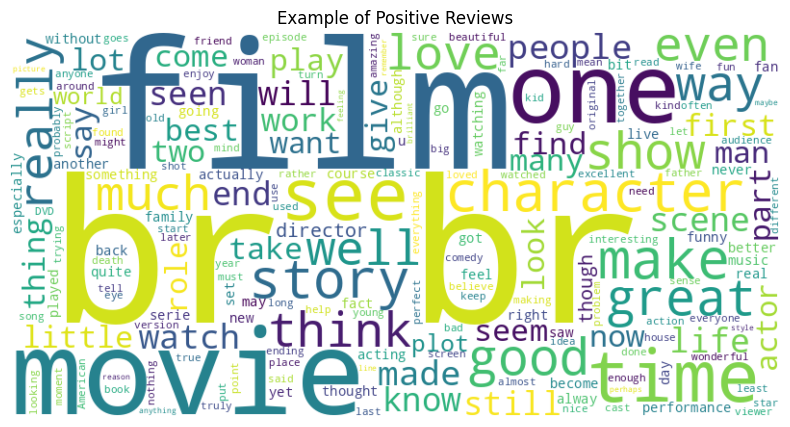

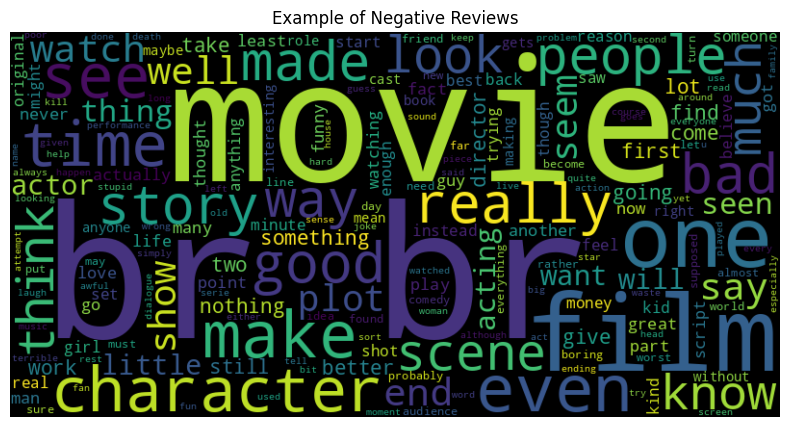

In [11]:
# we will show some of the most common words in the review using word clouds

positive_reviews = ' '.join(trn_dt[trn_dt['label'] == 1]['text'])
negative_reviews = ' '.join(trn_dt[trn_dt['label'] == 0]['text'])

# positive reviews
wordcloud_pst = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pst, interpolation='bilinear')
plt.title('Example of Positive Reviews')
plt.axis('off')
plt.show()

# negative reviews
wordcloud_ngt = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ngt, interpolation='bilinear')
plt.title('Example of Negative Reviews')
plt.axis('off')
plt.show()

## **4. Data Preprocessing**

In [12]:
# let us start with tokenization with BERT tokenizer

# first, we will be Initializing the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
# Define a function
def tokenize_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

# Applying in batches the function to the dataset
tokend_dt = dt.map(tokenize_batch, batched=True)

# Accessing the trained data that was tokenized
trn_inpt_id = tokend_dt['train']['input_ids']
trn_attion_mask = tokend_dt['train']['attention_mask']
trn_label = tokend_dt['train']['label']


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [14]:
# Preprocessing the test dataset
tokend_tst_dt = dt['test'].map(tokenize_batch, batched=True)

# Accessing the test data that was tokenized
tst_inpt_id = tokend_tst_dt['input_ids']
tst_attion_mask = tokend_tst_dt['attention_mask']
tst_label = tokend_tst_dt['label']

In [15]:
# We will then be splitting the data into training and validation sets-80% for training, 20% for validation
trn_inpt, vld_inpt, trn_lbel, vld_lbel = train_test_split(trn_inpt_id, trn_label,
                                                                      test_size=0.2, random_state=42)
trn_mask, vld_mask= train_test_split(trn_attion_mask,
                                                test_size=0.2, random_state=42)


# Encoding the training and validation tokenized text data into numerical values that is tensors
trn_inpt = torch.tensor(trn_inpt)
vld_inpt = torch.tensor(vld_inpt)
trn_lbel = torch.tensor(trn_lbel)
vld_lbel = torch.tensor(vld_lbel )
trn_mask = torch.tensor(trn_mask)
vld_mask = torch.tensor(vld_mask)

batch_size = 32

trn_dat = TensorDataset(trn_inpt, trn_mask, trn_lbel)
trn_dtlder = DataLoader(trn_dat, batch_size=batch_size, shuffle=True)

vld_dat = TensorDataset(vld_inpt, vld_mask, vld_lbel)
vld_dtlder = DataLoader(vld_dat, batch_size=batch_size, shuffle=False)


# Encoding the test tokenized text data into numerical values that is tensors
tst_inpt = torch.tensor(tst_inpt_id)
tst_mask = torch.tensor(tst_attion_mask)
tst_lbel = torch.tensor(tst_label)

# Create DataLoader for the test set
tst_dat = TensorDataset(tst_inpt, tst_mask, tst_lbel)
tst_dtlder = DataLoader(tst_dat, batch_size=batch_size, shuffle=False)

## **5. Model Selection, Fine-Tuning and Training**

In [16]:
# Selecting the model
# setting the device to GPU
device = 'cuda'

# Loading the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
# we will now start with Fine-Tuning and Training

batch_size = 32

trn_dtlder = DataLoader(trn_dat, batch_size=batch_size, shuffle=True, num_workers=4)
vld_dtlder = DataLoader(vld_dat, batch_size=batch_size, shuffle=False, num_workers=4)

# we will define the optimizer
optzer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 3
ttl_step = len(trn_dtlder) * epochs

# Creating the learning rate scheduler
schdler = get_linear_schedule_with_warmup(optzer, num_warmup_steps=0, num_training_steps=ttl_step)

# Defining a function to calculate the accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# The Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    model.train()

    total_loss = 0
    train_accuracy = 0

    for step, batch in enumerate(trn_dtlder):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optzer.step()
        schdler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        train_accuracy += flat_accuracy(logits, label_ids)

    avg_trn_acrcy = train_accuracy / len(trn_dtlder)
    avg_trn_ls = total_loss / len(trn_dtlder)

    print(f'Average training loss: {avg_trn_ls}')
    print(f'Average training accuracy: {avg_trn_acrcy}')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Average training loss: 0.29757613267302513
Average training accuracy: 0.87355
Epoch 2/3
Average training loss: 0.16283525968641044
Average training accuracy: 0.9418
Epoch 3/3
Average training loss: 0.0941570602916181
Average training accuracy: 0.97215


In [18]:
# The Validation loop
model.eval()
vld_acurcy = 0
nb_evl_step = 0

for batch in vld_dtlder:
    bh_inpt_id = batch[0].to(device)
    bh_inpt_mask = batch[1].to(device)
    bh_lbel = batch[2].to(device)

    with torch.no_grad():
        outputs = model(bh_inpt_id, attention_mask=bh_inpt_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    lbel_id = bh_lbel.cpu().numpy()

    vld_acurcy += flat_accuracy(logits, lbel_id)
    nb_evl_step += 1

print(f'Validation accuracy: {vld_acurcy/nb_evl_step}')

Validation accuracy: 0.9177945859872612


## **6. Evaluation**

In [29]:
# Testing the model and showing the evaluation metrics
# first we will put the model in an evaluation mode
model.eval()

# Initializing the lists to store true labels and predictions
true_lbel = []
prdtion = []

# Looping over the test data
for step, batch in enumerate(tst_dtlder):
    print(f"Processing batch {step+1}/{len(tst_dtlder)}")

    bt_inpt_id = batch[0].to(device)
    bt_inpt_mask = batch[1].to(device)
    bt_lbel = batch[2].to(device)

    with torch.no_grad():
        outpt = model(bt_inpt_id, attention_mask=bt_inpt_mask)

    logits = outpt.logits
    logits = logits.detach().cpu().numpy()
    lbel_id = bt_lbel.cpu().numpy()

# Storing the true label & prediction
    prdtion.extend(np.argmax(logits, axis=1).flatten())
    true_lbel.extend(lbel_id.flatten())

# Ensuring that both arrays are the same length
if len(true_lbel) == len(prdtion):


# Calculating the accuracy, precision, recall, and F1-score
  acracy = accuracy_score(true_lbel, prdtion)
  precisn = precision_score(true_lbel, prdtion)
  recll = recall_score(true_lbel, prdtion)
  f1 = f1_score(true_lbel, prdtion)

  print(f'Test Accuracy: {acracy }')
  print(f'Precision: {precisn}')
  print(f'Recall: {recll}')
  print(f'F1-Score: {f1}')

# Generating  classification report
  print("\nClassification Report:")
  print(classification_report(true_lbel, prdtion, target_names=['Negative', 'Positive']))

# Generating  confusion matrix
  print("\nConfusion Matrix:")
  print(confusion_matrix(true_lbel, prdtion))

else:
  print("Mismatch in lengths of true labels and predictions. Review data processing.")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Processing batch 1/782
Processing batch 2/782
Processing batch 3/782
Processing batch 4/782
Processing batch 5/782
Processing batch 6/782
Processing batch 7/782
Processing batch 8/782
Processing batch 9/782
Processing batch 10/782
Processing batch 11/782
Processing batch 12/782
Processing batch 13/782
Processing batch 14/782
Processing batch 15/782
Processing batch 16/782
Processing batch 17/782
Processing batch 18/782
Processing batch 19/782
Processing batch 20/782
Processing batch 21/782
Processing batch 22/782
Processing batch 23/782
Processing batch 24/782
Processing batch 25/782
Processing batch 26/782
Processing batch 27/782
Processing batch 28/782
Processing batch 29/782
Processing batch 30/782
Processing batch 31/782
Processing batch 32/782
Processing batch 33/782
Processing batch 34/782
Processing batch 35/782
Processing batch 36/782
Processing batch 37/782
Processing batch 38/782
Processing batch 39/782
Processing batch 40/782
Processing batch 41/782
Processing batch 42/782
P

## 7. Application and Deployment
Model Deployment: The fine-tuned model will be deployed in a real-world scenario, potentially within a business application to automatically classify new movie reviews based on sentiment. Deploying models effectively requires not only technical know-how but also an understanding of the business context, as discussed by Sculley et al. (2015).


In [30]:
# Saving the fine-tuned model and tokenizer
# Saving the tokenizer
tokenizer.save_pretrained('./sentiment_model')

# Saving the model
model.save_pretrained('./sentiment_model')


In [31]:
# We will be loading the model and tokenizer for inference

# Now, Loading the tokenizer
tokenizer = BertTokenizer.from_pretrained('./sentiment_model')

# Loading the model
model = BertForSequenceClassification.from_pretrained('./sentiment_model')
model.eval()

# then, loading to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
# Creating a function that accepts fresh text data and outputs the sentiment classification
def predict_sentiment(text):
    inp = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    inp_id = inp['input_ids'].to(device)
    ation_mask = inp['attention_mask'].to(device)

    with torch.no_grad():
        otpt = model(inp_id, attention_mask=ation_mask)

    logits = otpt.logits
    predted_cls_id = torch.argmax(logits, dim=1).item()

    if predted_cls_id == 1:
        return "Positive"
    else:
        return "Negative"


In [36]:
# Deploying the model using FLASK

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    da = request.get_json(force=True)
    tx = da['text']
    prdn = predict_sentiment(tx)
    return jsonify({'sentiment': prdn})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
